In [94]:
#starting parameters
import seaborn as sns
import numpy_financial as npf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
S0 = 1.28065 #starting price
v = 0.05 #percent increase / decrease in price per time
q = 1/2 #up probability
K = S0 #strike price
N = 10 #number of periods for binomial model
#interest rate modelled at 0

put_price = .09

In [73]:
def value_call(S0, v, K, N, q):
    #calculates the prices of a call option
    #spot prices at maturity
    S = np.zeros(N+1)
    S[0] = S0*(1-v)**N
    for i in range(1,N+1):
        S[i] = S[i-1]*(1+v)/(1-v)
    #initialize call prices array
    C = np.zeros(N+1)
    for i in range(0, N+1):
        C[i] = max(0,S[i] - K) #compute payoff at maturity
    for j in np.arange(N,0,-1):
        for i in range(0,j):
            C[i] = q*C[i+1] + (1-q) * C[i]
    return C[0]
 
def value_put(S0, v, K, N, q):
    #calculated using put call parity
    #C = P + S - PV(K)
    return value_call(S0, v, K, N, q) - S0 + K

def find_v(S0, put_price, K, N, q, guess = 0.5, min = 0, max = S0, accuracy = 0.0001):
    #finds the value of v for a given price, where parameter 'accuracy' sets how close you want to get
    while abs(max - min) > accuracy:
        print('running find_v, guess: ', guess)
        if value_put(S0, guess, K, N, q) < put_price:
            print('value > guess')
            min = guess
            guess = (max + guess) / 2
            return find_v(S0, put_price, K, N, q, guess, min, max, accuracy)
        else:
            print('value < guess')
            max = guess
            guess = (min + guess) / 2
            return find_v(S0, put_price, K, N, q, guess, min, max, accuracy)
    return guess


def max_Sj(S0, v, N):
    #max underlying price within N periods
    return S0 * (1+v)**N

def exp_S(S0, v, N):
    #expected value of underlying price in N periods
    S = np.zeros(N+1)
    S[0] = S0*(1-v)**N
    for i in range(1,N+1):
        S[i] = S[i-1]*(1+v)/(1-v)
    total_ST = sum(S)
    return sum(S) / (N + 1)

def end_paths_S(S0, v, N):
    #maps out only the end paths for the underlying in the binomial model
    S = np.zeros(N+1)
    S[0] = S0*(1-v)**N
    for i in range(1,N+1):
        S[i] = S[i-1]*(1+v)/(1-v)
    return S

def all_paths(S0, v, N):
    #maps out all the paths the binomial model can take
    values = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i+1):
            values[j,i] = S0 * ((1+v)**j) * ((1-v)**(i-j))
    for i in range(N+1):
        for j in range(i):
            values[i,j] = S0 * (1+v)**j
    return values

In [8]:
#calculate put and call price
callPrice = value_call(S0, v, K, N, q)
putPrice = value_put(S0, v, K, N, q)
putPrice


0.06501440827594052

In [9]:
#example to find v
v = find_v(S0, put_price, K, N, q, guess = 0.5, min = 0, max = S0, accuracy = 0.001)
v

running find_v, guess:  0.5
value < guess
running find_v, guess:  0.25
value < guess
running find_v, guess:  0.125
value < guess
running find_v, guess:  0.0625
value > guess
running find_v, guess:  0.09375
value < guess
running find_v, guess:  0.078125
value < guess
running find_v, guess:  0.0703125
value < guess
running find_v, guess:  0.06640625
value > guess
running find_v, guess:  0.068359375
value < guess
running find_v, guess:  0.0673828125
value < guess


0.06689453125

In [10]:
max_Sj(S0, v, N)

2.4470640896798415

In [11]:
exp_S(S0, v, 2)

1.2825602509697278

In [12]:
#IRR of the original cash flows in documents
cashflows_original = [
    -100_000_000,
    15_000_000,
    15_000_000,
    15_000_000,
    115_000_000,
]
npf.irr(cashflows_original)

0.15000000000000036

In [13]:
#IRR of the expected value of the cash flows
cashflows = [
    -100_000_000 * S0,
    15_000_000 * exp_S(S0, v, 2),
    15_000_000 * exp_S(S0, v, 4),
    15_000_000 * exp_S(S0, v, 6),
    115_000_000 * exp_S(S0, v, 8),
]
npf.irr(cashflows)


0.1607295089073384

In [57]:
test = all_paths(S0, v, N).tolist()
print(test)

[[1.28065, 1.1949815185546875, 1.1150437900185586, 1.0404534583620437, 0.9708528119774733, 0.9059080682074959, 0.8453077726291623, 0.7887613054171531, 0.7359974876231344, 0.6867632806874072, 0.6408225729461109], [1.28065, 1.3663184814453126, 1.2749192470908166, 1.1896341216750734, 1.110054104746614, 1.0357975557474508, 0.9665083637858295, 0.9018542398411719, 0.8415251232111717, 0.7852316945588618, 0.7327039884287035], [1.28065, 1.3663184814453126, 1.4577177157998085, 1.3602043725065596, 1.269214138603533, 1.184310653745777, 1.1050867477090722, 1.0311624877304868, 0.9621833564711719, 0.8978185518634814, 0.8377594006890199], [1.28065, 1.3663184814453126, 1.4577177157998085, 1.5552310590930576, 1.4511946064095864, 1.3541176234612888, 1.263534559782482, 1.1790110076876577, 1.100141618989802, 1.026548161078863, 0.9578777030379428], [1.28065, 1.3663184814453126, 1.4577177157998085, 1.5552310590930576, 1.6592675117765285, 1.5482715893578838, 1.4447006871400956, 1.348058111877306, 1.2578803963

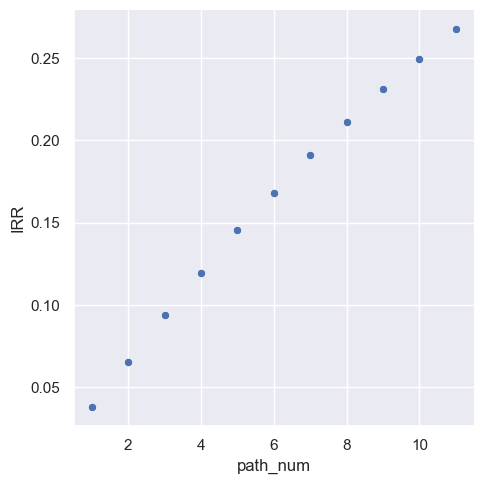

In [91]:
#calculate IRR for different paths with the cashflows provided, no option
paths = all_paths(S0, v, N).tolist()

#work out the cashflows expected along all possible paths
cashflows = []
for k in range(N + 1):
    cashflow = [-100_000_000 * S0] + [15_000_000] * 4 + [115_000_000]
    cashflows.append(cashflow)
for i in range(len(cashflows)):
    for j in range(1, len(cashflows[i])):
        cashflows[i][j] *= paths[i][j*2]

#calculate IRRs for the path
IRRs = [0] * (N+1)
for i in range(len(IRRs)):
    IRRs[i] = npf.irr(cashflows[i])
path_num = []
for i in range(len(IRRs)):
    path_num += [i+1]

#display the data
IRRdf = pd.DataFrame(list(zip(path_num, IRRs)), columns = ['path_num', 'IRR'])
IRRdf
sns.set_theme()
sns.relplot(
    data=IRRdf,
    x="path_num", y="IRR"
)

option_price:  8048787.275357072


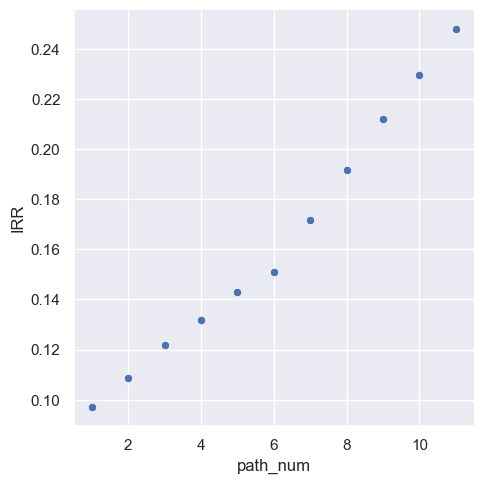

In [95]:
#calculate the IRRs using the option as a hedge
paths = all_paths(S0, v, N).tolist()
option_notional = 100_000_000
option_price = option_notional * value_put(S0, v, K, 10, q)
print("option_price: ", option_price)

#work out the cashflows expected along all possible paths
cashflows = []
for k in range(N + 1):
    cashflow = [-100_000_000 * S0 - option_price] + [15_000_000] * 4 + [115_000_000]
    cashflows.append(cashflow)
for i in range(len(cashflows)):
    for j in range(1, len(cashflows[i])):
        cashflows[i][j] *= paths[i][j*2]
        if j == 5:
            cashflows[i][j] += max(0, (K - paths[i][j*2]) * option_notional)

#calculate IRRs for the path
IRRs = [0] * (N+1)
for i in range(len(IRRs)):
    IRRs[i] = npf.irr(cashflows[i])
path_num = []
for i in range(len(IRRs)):
    path_num += [i+1]

#display the data
IRRdf = pd.DataFrame(list(zip(path_num, IRRs)), columns = ['path_num', 'IRR'])
IRRdf
sns.set_theme()
sns.relplot(
    data=IRRdf,
    x="path_num", y="IRR"
)